<a href="https://colab.research.google.com/github/jihye134seo/AI_Study/blob/main/finalfinalfinalfinalfinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim
from torch.optim.lr_scheduler import StepLR

# dataset and transformation
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os

from torchvision import utils
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from torchsummary import summary
import time
import copy

In [ ]:
train_transformation = transforms.Compose([
                        transforms.Resize(256),
                        transforms.CenterCrop(224),
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

val_transformation = transforms.Compose([
                        transforms.Resize(256),
                        transforms.CenterCrop(224),
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

In [ ]:
train_ds = datasets.ImageFolder(root = '/content/drive/MyDrive/final_train_val/train',transform = train_transformation)
val_ds = datasets.ImageFolder(root = '/content/drive/MyDrive/final_train_val/val', transform = val_transformation)

In [ ]:
train_dl = DataLoader(train_ds, batch_size = 32, shuffle = True)
val_dl = DataLoader(val_ds, batch_size = 32, shuffle = True)

In [ ]:
class BasicBlock(nn.Module):
  expansion = 1
  def __init__(self, in_channels, out_channels, stride = 1):
    super().__init__()

    self.residual_function = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1, bias = False),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(),
        nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size = 3, stride = 1, padding = 1, bias = False),
        nn.BatchNorm2d(out_channels * BasicBlock.expansion),
    )
    self.shortcut = nn.Sequential()
    self.relu = nn.LeakyReLU()

    if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_channels, out_channels*BasicBlock.expansion, kernel_size = 1, stride = stride, bias = False),
          nn.BatchNorm2d(out_channels*BasicBlock.expansion)
      )
  def forward(self, x):
    x = self.residual_function(x) + self.shortcut(x)
    x = self.relu(x)
    return x

In [ ]:
class ResNet(nn.Module):
  def __init__(self, block, num_block, num_classes = 20, init_weights = True):
    super().__init__()

    self.in_channels = 64
    self.conv1 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3, bias = False),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding = 1)
    )
    self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
    self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
    self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
    self.conv5_x = self._make_layer(block, 512, num_block[3], 2)

    self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
    self.fc = nn.Linear(512 * block.expansion, num_classes)

    # weights inittialization
    if init_weights:
      self._initialize_weights()

  def _make_layer(self, block, out_channels, num_blocks, stride):
    strides = [stride] + [1] * (num_blocks - 1)
    layers = []
    for stride in strides :
      layers.append(block(self.in_channels, out_channels, stride))
      self.in_channels = out_channels * block.expansion
    
    return nn.Sequential(*layers)

  def forward(self,x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        x = self.conv3_x(output)
        x = self.conv4_x(x)
        x = self.conv5_x(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    # define weight initialization function
  def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
def resnet18():
    return ResNet(BasicBlock, [2,2,2,2])


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = resnet18().to(device)
x = torch.randn(3, 3, 224, 224).to(device)
output = model(x)
print(output.size())

torch.Size([3, 20])


In [ ]:
summary(model, (3, 224, 224), device = device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
         LeakyReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
         LeakyReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
        LeakyReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
        LeakyReLU-14           [-1, 64,

In [ ]:
loss_func = nn.CrossEntropyLoss(reduction = 'sum')
opt = optim.Adam(model.parameters(), lr = 0.001)

from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor = 0.1, patience=10)

In [ ]:
def get_lr(opt):
  for param_group in opt.param_groups:
    return param_group['lr']

In [ ]:
def metric_batch(output, target):
  pred = output.argmax(1, keepdim=True)
  corrects = pred.eq(target.view_as(pred)).sum().item()
  return corrects

def loss_batch(loss_func, output, target, opt=None):
  loss = loss_func(output, target)
  metric_b = metric_batch(output, target)

  if opt is not None:
    opt.zero_grad()
    loss.backward()
    opt.step()
  
  return loss.item(), metric_b

In [ ]:
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
  running_loss = 0.0
  running_metric = 0.0
  len_data = len(dataset_dl.dataset)

  for xb, yb in dataset_dl:
    xb = xb.to(device)
    yb = yb.to(device)
    output = model(xb)

    loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

    running_loss += loss_b

    if metric_b is not None:
      running_metric += metric_b

    if sanity_check is True:
      break
    
  loss = running_loss / len_data
  metric = running_metric / len_data

  return loss, metric

In [ ]:
def train_val(model, params):
    num_epochs=params['num_epochs']
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]

    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}

    best_loss = float('inf')

    start_time = time.time()

    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs-1, current_lr))

        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)
        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)

        torch.save(model.state_dict(), path2weights)
        print('save model.pth')

        lr_scheduler.step(val_loss)

        print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
        print('-'*10)

    return model, loss_history, metric_history

In [ ]:
params_train = {
    'num_epochs':20,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'val_dl':val_dl,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'/content/drive/MyDrive/models/models_001.pth',
}

# create the directory that stores weights.pt
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('/content/drive/MyDrive/models')

In [ ]:
model, loss_hist, metric_hist = train_val(model, params_train)

Epoch 0/19, current lr=0.001


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


save model.pth
train loss: 2.705352, val loss: 4.327742, accuracy: 10.51, time: 27.6870 min
----------
Epoch 1/19, current lr=0.001
save model.pth
train loss: 2.452964, val loss: 2.585716, accuracy: 22.99, time: 41.4024 min
----------
Epoch 2/19, current lr=0.001
save model.pth
train loss: 2.292002, val loss: 14.276025, accuracy: 7.33, time: 57.4376 min
----------
Epoch 3/19, current lr=0.001
save model.pth
train loss: 2.111380, val loss: 2.957200, accuracy: 22.30, time: 71.7990 min
----------
Epoch 4/19, current lr=0.001
save model.pth
train loss: 1.971507, val loss: 2.969793, accuracy: 23.49, time: 85.8678 min
----------
Epoch 5/19, current lr=0.001
save model.pth
train loss: 1.843052, val loss: 4.194115, accuracy: 14.77, time: 99.7135 min
----------
Epoch 6/19, current lr=0.001
save model.pth
train loss: 1.705902, val loss: 8.702354, accuracy: 10.51, time: 114.3552 min
----------
Epoch 7/19, current lr=0.001
save model.pth
train loss: 1.590973, val loss: 2.019638, accuracy: 42.42, t

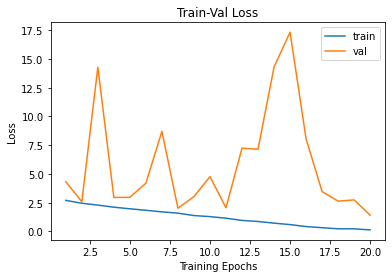

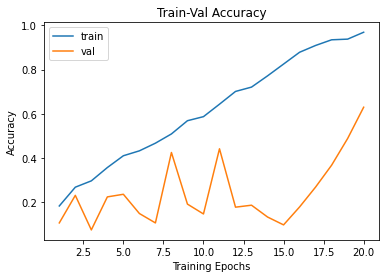

In [18]:
num_epoches = params_train["num_epochs"]

plt.title("Train-Val Loss")
plt.plot(range(1, num_epoches + 1), loss_hist["train"], label = "train")
plt.plot(range(1, num_epoches + 1), loss_hist["val"], label= "val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

plt.title("Train-Val Accuracy")
plt.plot(range(1, num_epoches + 1), metric_hist["train"], label = "train")
plt.plot(range(1, num_epoches + 1), metric_hist["val"], label = "val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()


In [ ]:
# 실사 + 일러의 10개 뽑기

# import
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import pandas as pd
import matplotlib.pyplot as plt
import os
import sklearn as sk
import random
from keras.preprocessing import image

#from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 


# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


def extract_features(file, model): 
  img = cv2.imread(file)
  img = cv2.resize(img, (224, 224))
  imgx = preprocess_input(np.array([img]))
  features = model.predict(imgx, use_multiprocessing=True)
  return features


def make_cluster(src):
  filesets = os.listdir(src)
  fileset = list(set(filesets))
    
  model = VGG16()
  model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

  data = {}
  for file in filesets:
    feat = extract_features(src + "/" + file, model)
    data[file] = feat

  filenames = np.array(list(data.keys()))
  feat = np.array(list(data.values()))

  feat = feat.reshape(-1,4096)
  feat.shape

  pca = PCA(n_components=100, random_state=22)
  pca.fit(feat)
  x = pca.transform(feat)

  kmeans = KMeans(n_clusters=2, random_state=22)
  kmeans.fit(x)

  groups = {}
  for file, cluster in zip(filenames, kmeans.labels_):
      if cluster not in groups.keys():
          groups[cluster] = []
          groups[cluster].append(file)
      else:
          groups[cluster].append(file)
  return groups


def decision(src):
  img = cv2.imread(src)
  img = cv2.resize(img, (100, 100))
  hist_ = cv2.calcHist([img], [0], None, [256], [0,256])
  #std = int(hist_.var())
  hist_[hist_ < (hist_[hist_.argmax()])//4] = 0
  frequency = len(np.unique(hist_))

  return frequency 
  

def match(group1, group2):
  group1list = []
  group2list = []

  for g1 in group1:
      group1list.append(decision(src + '/' + g1))
  for g2 in group2:
     group2list.append(decision(src + '/' + g2))
  print("g0 : ", group1list)
  print("g1 : ", group2list)
  
  return max(group1list), max(group2list)
 
def remove_Real_image(src, groups):
  for g in groups:
    file_path = src + '/' + g
    if os.path.isfile(file_path):
      os.remove(file_path)
        


file_dir = "/content/drive/MyDrive/tmp/L2_"

classlist = ['10', '12', '15', '20', '21', '24', '25', '27', '3', '30', '33', '34', \
              '39', '40', '41', '44', '45', '46', '50', '52']


for c in range(len(classlist)):  # len(classlist) 
  src = file_dir + classlist[c]
  groups_ = make_cluster(src)
  ret_g0, ret_g1 = match(random.sample(groups_[0], 15), random.sample(groups_[1], 15)) 
  print(classlist[c], ' : ')

  if ret_g0 > 15:               # ret_g0 is real
    remove_Real_image(src, groups_[0])
    print("그룹0이 실사이므로 삭제되었습니다.")
  elif ret_g1 > 15:             # ret_g1 is real
    is_real = True
    remove_Real_image(src, groups_[1])
    print("그룹1이 실사이므로 삭제되었습니다.")
  else:
    print("클래스 모두 일러입니다.")
